# Extraction of cell cycle phases by hierarchical clustering

We try to extract the phases of the cell cycle from our temporal network. We do so by:
1. Compute similarity/distance between every pair of adjacency snapshot
2. Perform hierarchical clustering on these distances

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
# import pathpy as pp
import teneto as tnt
import pandas as pd

from sklearn import metrics
import scipy

import seaborn as sb
sb.set_context("paper")

import temp_utils as tu
import chen2temporal_utils as c2t
import cluster_snapshots as cs

from matplotlib import animation
from networkx.drawing.nx_agraph import graphviz_layout
import matplotlib.cm as cm
import matplotlib as mpl

import scipy.cluster.hierarchy as shc

import ipywidgets as widgets
from ipywidgets import interact, interact_manual

from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

## Load our cell cycle temporal network

In [2]:
# df_tedges  = pd.read_csv("temporal_net.tedges") 

datafile = "tedges_combined_weighted_binary_method_percentage_p_0.5_clean2.tedges"
# datafile = "tedges_combined_weighted_binary_method_percentage_minmax_p_0.5_clean2.tedges"

dir_ = ""

# datafile = "tedges_combined_weighted_binary_method_percentage_p_0.9_clean2.tedges"
# dir_ = "threshold_robustness/"

df_tedges  = pd.read_csv(datafile, sep="\s*\t\s*", engine='python')
tag = datafile[25:-14]

df_tedges = df_tedges.rename(columns={"source": "i", "target": "j", "time" : "t", "weight" : 'w'})

df_tedges.head()

nodes = sorted(set(df_tedges[['i', 'j']].values.flatten()))
times = sorted(set(df_tedges['t']))
N = len(nodes)

# {label : id}
node_ids = {key : i for i,key in enumerate(nodes)} 
# {id : label}
node_labels = {i : key for i,key in enumerate(nodes)}

df_tedges = df_tedges.replace(node_ids)
df_tedges

# /!\ because of bug of teneto when dealing with initial time > 0, we shift all times -100
df_tedges['t'] -= 100
times = sorted(set(df_tedges['t']))

df_tedges

,i,j,t,w
0,0,4,0.0,1.0
1,0,4,1.0,1.0
2,0,4,2.0,1.0
3,0,4,3.0,1.0
4,0,4,4.0,1.0
...,...,...,...,...
16372,77,82,98.0,1.0
16373,77,82,99.0,1.0
16374,77,82,100.0,1.0
16375,77,82,101.0,1.0


In [3]:
tnet = tnt.TemporalNetwork(from_df=df_tedges, starttime=times[0])

In [4]:
# https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/

## Test on toy snapshots

In [5]:
N = 3
T = 4
snapshots = np.random.randint(2, size=(T, N, N))

# 1 Compute distances
# -------------------

# 1st test: Eucledian distance
dist_mat = np.zeros((T, T))

for i in range(T):
    for j in range(i) :
        dist_mat[j,i] = np.linalg.norm(snapshots[i] - snapshots[j]) # Eucledian distance
        
        
# extract condensed distance matrix need for the clustering
# id_l = np.tril_indices(n=T, k=-1) # indices of lower triangle elements
id_u = np.triu_indices(n=T, k=1) # indices of lower triangle elements

# dist_mat_condensed = dist_mat[id_l]
dist_mat_condensed = dist_mat[id_u]

In [6]:
snapshots

array([[[1, 0, 0],
        [1, 1, 0],
        [0, 1, 0]],

       [[0, 1, 0],
        [0, 0, 1],
        [1, 1, 1]],

       [[0, 0, 1],
        [0, 1, 0],
        [0, 0, 0]],

       [[1, 1, 1],
        [0, 0, 1],
        [0, 0, 1]]])

In [7]:
dist_mat

array([[0.        , 2.64575131, 2.        , 2.64575131],
       [0.        , 0.        , 2.64575131, 2.        ],
       [0.        , 0.        , 0.        , 2.23606798],
       [0.        , 0.        , 0.        , 0.        ]])

In [8]:
dist_mat_condensed

array([2.64575131, 2.        , 2.64575131, 2.64575131, 2.        ,
       2.23606798])

[[0. 2. 2. 2.]
 [1. 3. 2. 2.]
 [4. 5. 3. 4.]]


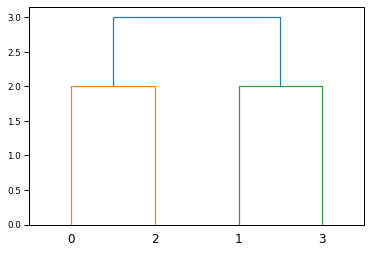

In [9]:
# 2. Perform the clustering

linked = shc.linkage(dist_mat_condensed, method="ward")

print(linked)

fig, ax = plt.subplots()
dend = shc.dendrogram(linked)

plt.show()

## Test on temporal network of cell cycle

In [10]:
# # set layout positions from agg net
# snapshots = tnet.df_to_array()
# snapshots = np.swapaxes(snapshots, 0, 2) # put time as zeroth axis
# print(snapshots.shape)
# T = tnet.T

# # 1 Compute distances
# # -------------------

# # 1st test: Eucledian distance
# dist_mat = np.zeros((T, T))

# for i in range(T):
#     for j in range(i) :
#         dist_mat[j,i] = np.linalg.norm(snapshots[i] - snapshots[j]) # Eucledian distance
        
        
# # extract condensed distance matrix need for the clustering
# # id_l = np.tril_indices(n=T, k=-1) # indices of lower triangle elements
# id_u = np.triu_indices(n=T, k=1) # indices of lower triangle elements

# # dist_mat_condensed = dist_mat[id_l]
# dist_mat_condensed = dist_mat[id_u]

# dist_mat_full = dist_mat + dist_mat.T

In [11]:
T = tnet.T
dist_mat, dist_mat_condensed = cs.compute_snapshot_distances(tnet, dist='eucledian')

In [12]:
T

103

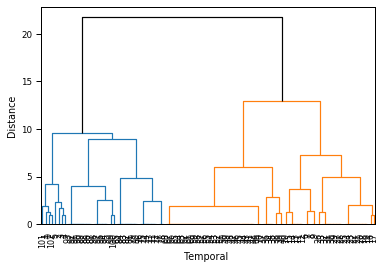

In [13]:
# 2. Perform the clustering

linked = shc.linkage(dist_mat_condensed, method="ward")

# print(linked)
cmap = cm.tab10(np.linspace(0, 1, 10))
shc.set_link_color_palette([mpl.colors.rgb2hex(rgb[:3]) for rgb in cmap])

fig, ax = plt.subplots()
dend = shc.dendrogram(linked,
                     leaf_rotation=90,  # rotates the x axis labels
                     leaf_font_size=8,  # font size for the x axis labels)
                     above_threshold_color='black')

ax.set_ylabel("Distance")

ax.set_xlabel("Temporal ")

plt.show()

### Run Chen

In [14]:
from xppcall import xpprun, read_pars_values_from_file
from labellines import *

npa, variables = xpprun('bychen04_xpp.ode', clean_after=True)

i_st = 100
i_end = 203

times = npa[i_st:i_end,0]
npa = npa[i_st:i_end,:]

series = lambda name : npa[:, 1+variables.index(name)]
variables = [var.upper() for var in variables]
data = {var : series(var) for var in variables}

def normed(x) :
    return x / np.max(x)

def plot_concentrations(var, times=times, ax=None, norm=False) :
    
    if ax==None :
        fig = plt.figure()
        ax = plt.gca()
        
    for i in var :
        if norm:
            ax.plot(times, normed(data[i]), label=i)
        else :
            ax.plot(times, series(i), label=i)

#     ax.legend()
    ax.set_xlabel('Time (min)')
    if norm :
        ax.set_ylabel('Concentration (normed)')
    else :
        ax.set_ylabel('Concentration')

    sb.despine()
    
    return ax

In [15]:
times

array([100., 101., 102., 103., 104., 105., 106., 107., 108., 109., 110.,
       111., 112., 113., 114., 115., 116., 117., 118., 119., 120., 121.,
       122., 123., 124., 125., 126., 127., 128., 129., 130., 131., 132.,
       133., 134., 135., 136., 137., 138., 139., 140., 141., 142., 143.,
       144., 145., 146., 147., 148., 149., 150., 151., 152., 153., 154.,
       155., 156., 157., 158., 159., 160., 161., 162., 163., 164., 165.,
       166., 167., 168., 169., 170., 171., 172., 173., 174., 175., 176.,
       177., 178., 179., 180., 181., 182., 183., 184., 185., 186., 187.,
       188., 189., 190., 191., 192., 193., 194., 195., 196., 197., 198.,
       199., 200., 201., 202.])

min of mass: [1.2040126] at indices (array([1]),)


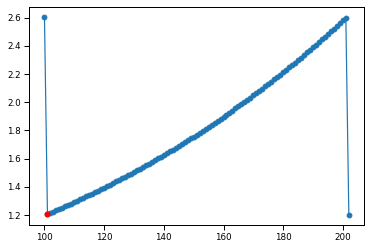

In [16]:
plt.figure()

# find minima
id_min_mass = scipy.signal.argrelextrema(series('MASS'), np.less)
mass_min = series('MASS')[id_min_mass]

plt.plot(times, series('MASS'), 'o-')



plt.plot(times[id_min_mass], mass_min, 'ro')

print(f"min of mass: {mass_min} at indices {id_min_mass}")


In [17]:
def plot_events(ax=None) :
    
    if ax==None:
        ax = plt.gca()
        
    y_pos = 1.01 * ax.get_ylim()[1]
    
    events_chen = [33, 84,36, 100]
    event_chen_names = ['bud', 'spn', 'ori', 'mass']
    for i, event in enumerate(events_chen) :
        ax.axvline(x=event, c='k', label=event_chen_names[i], zorder=-1)
        ax.text(event, y_pos , event_chen_names[i], #transform=ax.transAxes,
                fontsize='small', rotation=90, va='bottom', ha='center')

    events = ['START', 'E3']
    events_times = [5, 70]
    for i, event in enumerate(events):
        ax.axvline(x=events_times[i], c='k', ls='--', label=event[i], zorder=-1)
        ax.text(events_times[i], y_pos, events[i], #transform=ax.transAxes,
                fontsize='small', rotation=90, va='bottom', ha='center')
        
def plot_phases(ax=None, y_pos=None) :
    
    if ax==None:
        ax = plt.gca()
    if y_pos==None: 
        y_pos = 1.01 * ax.get_ylim()[1]

        
    phases = np.array([0, 35, 70, 78, 100])
    phases_mid = (phases[:-1] + phases[1:]) / 2
    phases_labels = ['G1', 'S', 'G2', 'M']

    for i in range(len(phases)-1) :
        ax.axvspan(xmin=phases[i], xmax=phases[i+1], ymin=0, ymax=0.1, color='k', alpha=+ 0.15*i)

        ax.text(phases_mid[i], -1, phases_labels[i], fontweight='bold', 
                 va='bottom', ha='center')

In [18]:
def plot_silhouette_sample(silhouette_sample, clusters, silhouette_avg, ax=None) :

    if ax==None:
        ax = plt.gca()
        
    n_clust = len(set(clusters))
    if n_clust > 10 :
        sb.set_palette("tab20")
    else : 
        sb.set_palette("tab10")
        
    y_lower = 1
    for i in range(1, n_clust+1):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = silhouette_sample[clusters == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

#         color = plt.cm.nipy_spectral(float(i) / n_clust)
        ax.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=f"C{i-1}", edgecolor=f"C{i-1}", alpha=1)

        # Label the silhouette plots with their cluster numbers at the middle
#         ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        hpad = 1
        y_lower = y_upper + hpad  # 10 for the 0 samples

    ax.axvline(x=silhouette_avg, c='k', ls='--')

    # ax.set_ylim(1, len(clusters) + n_clust*hpad)

    # ax.set_title(f"The silhouette plot for the {n_clust} clusters.")
#     ax.set_xlabel("The silhouette coefficient values")
#     ax.set_ylabel("Cluster label")
#     ax.set_yticks([])
    sb.despine()


#### Complete plot

In [19]:
times

array([100., 101., 102., 103., 104., 105., 106., 107., 108., 109., 110.,
       111., 112., 113., 114., 115., 116., 117., 118., 119., 120., 121.,
       122., 123., 124., 125., 126., 127., 128., 129., 130., 131., 132.,
       133., 134., 135., 136., 137., 138., 139., 140., 141., 142., 143.,
       144., 145., 146., 147., 148., 149., 150., 151., 152., 153., 154.,
       155., 156., 157., 158., 159., 160., 161., 162., 163., 164., 165.,
       166., 167., 168., 169., 170., 171., 172., 173., 174., 175., 176.,
       177., 178., 179., 180., 181., 182., 183., 184., 185., 186., 187.,
       188., 189., 190., 191., 192., 193., 194., 195., 196., 197., 198.,
       199., 200., 201., 202.])

KeyError: 'CLN3'

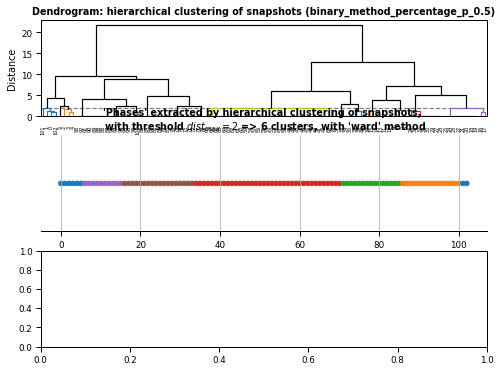

In [20]:
fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(8, 6))

d_max = 2

# 2. Perform the clustering
method = "ward"  #"complete" #"average" #
maxclust = 6

linked = shc.linkage(dist_mat_condensed, method=method) #"ward")
# clusters = shc.fcluster(linked, d_max, criterion='distance')
clusters = shc.fcluster(linked, maxclust, criterion='maxclust')

n_clusters = len(set(clusters))

cmap = cm.tab10(np.linspace(0, 1, 10))
shc.set_link_color_palette([mpl.colors.rgb2hex(rgb[:3]) for rgb in cmap])
# print(linked)

dend = shc.dendrogram(linked,
                     leaf_rotation=90,  # rotates the x axis labels
                     color_threshold=d_max,
                     above_threshold_color='black',
#                      link_color_func=lambda k: clusters[k],
                     ax=ax1)  # font size for the x axis labels)

ax1.axhline(y=d_max, c='grey', ls='--', zorder=1)

ax1.set_title(f"Dendrogram: hierarchical clustering of snapshots ({tag})", weight="bold")
ax1.set_ylabel("Distance")
ax1.set_xlabel("Time indices")

#-----------------------------------------------------------------

times = np.array(list(set(tnet.network.t))) # todo: deal with times in tnet, must be over 100

n_colors = 10

# colors = [f"C{i}" for i in clusters]
cmap = cm.tab10

sc = ax2.scatter(times, times*0, c=clusters, cmap=cmap, vmin=1, vmax=n_colors)

ax2.set_yticks([])
# ax2.set_aspect(aspect=200)
sb.despine(ax=ax2, left=True)
ax2.grid(axis='x')

ax2.set_title("'Phases' extracted by hierarchical clustering of snapshots, \n with threshold $dist_{{max}} \
              = {}$ => {} clusters, with '{}' method" .format(d_max, n_clusters, method), weight="bold")
# plt.colorbar(sc, ticks=range(1,n_colors+1))


#======================================

sb.set_palette('Dark2', n_colors=8)
var = ['CLN3', 'CLN2', 'CLB5', 'CLB2','MASS'] # +['ori']

t_G1 = 0
t_S = 36  # duration of G1, 36 min [Chen]
t_G2 = 78
t_M = 90
# cycle time, 101 min [Chen]

# phases = np.array([t_G1, t_S, t_G2, t_M, 100])
phases = np.array([0, 35, 70, 78, 100])
phases_mid = (phases[:-1] + phases[1:]) / 2
phases_labels = ['G1', 'S', 'G2', 'M']

plot_concentrations(var, times=times[:], ax=ax3, norm=True)
labelLines(plt.gca().get_lines(),zorder=2.5, xvals=[10, 90, 95, 55, 30])

for i in range(len(phases)-1) :
    ax3.axvspan(xmin=phases[i], xmax=phases[i+1], color='k', alpha=+ 0.1*i)
    
    ax3.text(phases_mid[i], 1.1, phases_labels[i], fontweight='bold', 
             va='bottom', ha='center')

#------------------------------------ plot events

events_chen = [33, 84,36, 100]
event_chen_names = ['bud', 'spn', 'ori', 'mass']
for i, event in enumerate(events_chen) :
    ax2.axvline(x=event, c='k', label=event_chen_names[i], zorder=-2)
    ax2.text(event, 0.005, event_chen_names[i], fontsize='small', rotation=90, va='bottom', ha='right')

events = ['START', 'E3']
events_times = [5, 70]
for i, event in enumerate(events):
    ax2.axvline(x=events_times[i], c='k', ls='--', label=event[i], zorder=-2)
    ax2.text(events_times[i], 0.005, events[i], fontsize='small', rotation=90, va='bottom', ha='right')
    
    
# ax2.legend()

# plt.tight_layout()

ax2.get_shared_x_axes().join(ax2, ax3)
ax3.autoscale()
plt.subplots_adjust(hspace=0.9)

# plt.savefig(f"phases_from_clustering_maxclust_{maxclust}_mtd_{method}.png", dpi=250, bbox_inches="tight")
plt.savefig(f"{dir_}phases_from_clustering_maxclust_{maxclust}_mtd_{method}_{tag}.png", dpi=250, bbox_inches="tight")
plt.savefig(f"{dir_}phases_from_clustering_maxclust_{maxclust}_mtd_{method}_{tag}.pdf", dpi=250, bbox_inches="tight")

plt.show()



In [21]:
methods = ['single', 'complete', 'average', 'ward']
i = 3
method = methods[i]

# compute dendrogram
linked = shc.linkage(dist_mat_condensed, method=method) #"ward")

maxclust_max = 15
maxclust_range = range(1, maxclust_max)
n_maxclust = len(maxclust_range)
clusters_arr = np.zeros((n_maxclust, T))
n_clust_arr = np.zeros(n_maxclust)

silhouette_avg_arr = np.zeros((n_maxclust))
silhouette_sample_arr = np.zeros((n_maxclust, T))

times = np.array(list(set(tnet.network.t))) # todo: deal with times in tnet, must be over 100

# compute array of clusters
for i, maxclust in enumerate(maxclust_range) :
    
    # compute clusters
    clusters = shc.fcluster(linked, maxclust, criterion='maxclust')
    
    clusters_arr[i] = clusters

    n_clusters = len(set(clusters))
    n_clust_arr[i] = n_clusters
    
    if n_clusters > 1 :
        silhouette_avg = metrics.silhouette_score(dist_mat, clusters, metric="precomputed")
        silhouette_avg_arr[i] = silhouette_avg
        
        silhouette_sample = metrics.silhouette_samples(dist_mat, clusters, metric="precomputed")
        silhouette_sample_arr[i] = silhouette_sample 
    

AttributeError: module 'cluster_snapshots' has no attribute 'plot_time_clusters'

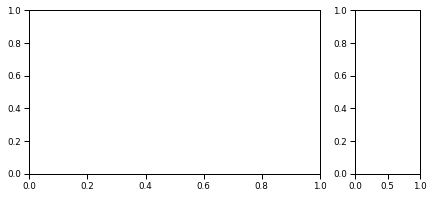

In [22]:
# plot array of clusters   

gridspec_kw={"width_ratios": [9,2]}

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 3), gridspec_kw=gridspec_kw)

#-------------- main plot with time clusters
cs.plot_time_clusters(times, clusters_arr, ax=ax1)

ax1.set_ylabel("Max # clusters")
ax1.set_xlabel("Times (min)")

ax1.set_xticks(range(0, 100+5, 10))
ax1.set_ylim([-1, ax1.get_ylim()[1]])
ax1.grid(axis="x")
ax1.set_axisbelow(True)
sb.despine(ax=ax1)

#---------------- twin plot for labels on right
ax11 = ax1.twinx()
ax11.set_ylim(ax1.get_ylim())
ax11.set_yticks(maxclust_range)

labels_right = [int(n_clust) if (i==0 or np.diff(n_clust_arr)[i-1]!=0) else '' for i, n_clust in enumerate(n_clust_arr)]
ax11.set_yticklabels(labels_right)
sb.despine(ax=ax11, right=False)

# ax2.set_ylabel("Actual # clusters")

#----------- side plot
# divider = make_axes_locatable(ax)
# ax3 = divider.append_axes("top", 1.2, pad=0.1, sharex=axScatter)
# ax2 = divider.append_axes("right", size=1, pad=0.5)#, sharey=ax)

ax2.plot(silhouette_avg_arr, n_clust_arr, 'ko-')
ax2.set_xlim(xmax=1.1)
ax2.set_ylim(ax1.get_ylim())
ax2.set_yticks(maxclust_range)
ax2.set_yticklabels(labels_right)
ax2.set_ylabel("Actual # clusters")
ax2.set_xlabel("Average silhouette")

fig.suptitle(f"Hier. clust. method: '{method}' ({tag})")

plot_events(ax=ax1)
plot_phases(ax=ax1)

plt.subplots_adjust(wspace=0.4, top=0.8)

# plt.savefig(f"phase_clusters_all_method_{method}.png", dpi=250, bbox_inches="tight")
plt.savefig(f"{dir_}phase_clusters_all_method_{method}_{tag}.png", dpi=250, bbox_inches="tight")
plt.savefig(f"{dir_}phase_clusters_all_method_{method}_{tag}.pdf", dpi=250, bbox_inches="tight")

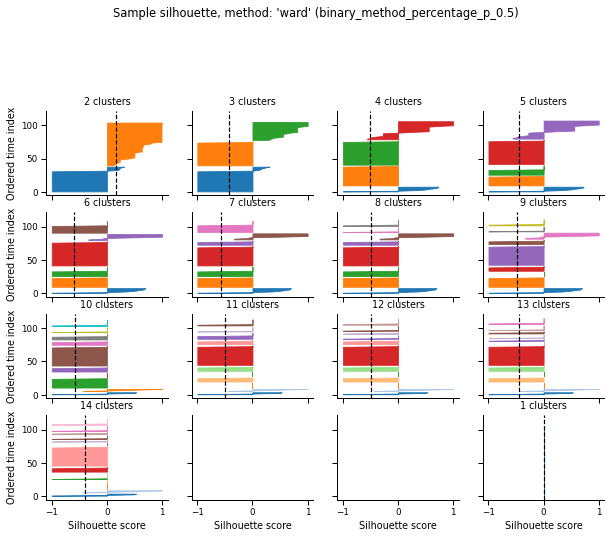

In [23]:
n_clust_unique, idx_unique = np.unique(n_clust_arr, return_index=True) # indices of unique n_clust values
ncols = 4
n_unique = len(n_clust_unique) -1 # minus the 1-cluster
nrows = n_unique // ncols + n_unique % ncols

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey=True, figsize=(10, 2 * nrows))

for i, j_uni in enumerate(idx_unique): 
    
    ax = axs.flatten()[i-1]
    
    n_clusters = len(set(clusters_arr[j_uni]))
    
    ax.set_title(f"{n_clusters} clusters")
    plot_silhouette_sample(silhouette_sample_arr[j_uni], clusters_arr[j_uni], silhouette_avg_arr[j_uni], ax=ax)

    
if nrows > 1 :
    axes_left = axs[:,0]
else : 
    axes_left = [axs[0]]
    
for ax in axes_left :
    ax.set_ylabel("Ordered time index")

for ax in axs.flatten()[-ncols:] :
    ax.set_xlabel("Silhouette score")

fig.suptitle(f"Sample silhouette, method: '{method}' ({tag})")

plt.subplots_adjust(top=0.8)

plt.savefig(f"{dir_}phase_clusters_silhouette_sample_method_{method}_{tag}.png", dpi=250, bbox_inches="tight")
plt.savefig(f"{dir_}phase_clusters_silhouette_sample_method_{method}_{tag}.pdf", dpi=250, bbox_inches="tight")

## K-means

In [24]:
snapshots = tnet.df_to_array()
snapshots = np.swapaxes(snapshots, 0, 2) # put time as zeroth axis
snapshot_flat = snapshots.reshape(T, -1) # each matrix is flattened, represented as a vector

print(snapshots.shape)

(103, 83, 83)


In [25]:
# methods = ['single', 'complete', 'average', 'ward']
# i = 3
# method = methods[i]
method = "kmeans"

# # compute dendrogram
# linked = shc.linkage(dist_mat_condensed, method=method) #"ward")

maxclust_max = 15
maxclust_range = range(1, maxclust_max)
n_maxclust = len(maxclust_range)
clusters_arr = np.zeros((n_maxclust, T))
n_clust_arr = np.zeros(n_maxclust)

silhouette_avg_arr = np.zeros((n_maxclust))
silhouette_sample_arr = np.zeros((n_maxclust, T))


# compute array of clusters
for i, nclust in enumerate(maxclust_range) :
    
    # compute clusters
#     clusters = shc.fcluster(linked, maxclust, criterion='maxclust')
    clusters = KMeans(n_clusters=nclust, random_state=None).fit_predict(snapshot_flat)
    
    clusters_arr[i] = clusters

    n_clusters = len(set(clusters))
    n_clust_arr[i] = n_clusters
    
    if n_clusters > 1 :
        silhouette_avg = metrics.silhouette_score(snapshot_flat, clusters, metric="euclidean")
        silhouette_avg_arr[i] = silhouette_avg
        
        silhouette_sample = metrics.silhouette_samples(snapshot_flat, clusters, metric="euclidean")
        silhouette_sample_arr[i] = silhouette_sample 
    

AttributeError: module 'cluster_snapshots' has no attribute 'plot_time_clusters'

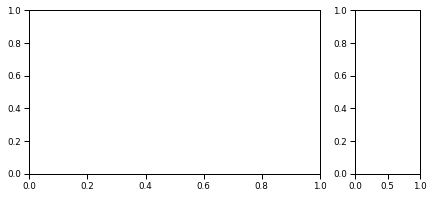

In [26]:
# plot array of clusters   

gridspec_kw={"width_ratios": [9,2]}

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 3), gridspec_kw=gridspec_kw)

times = np.array(list(set(tnet.network.t))) # todo: deal with times in tnet, must be over 100
#-------------- main plot with time clusters
cs.plot_time_clusters(times, clusters_arr, ax=ax1)

ax1.set_ylabel("Max # clusters")
ax1.set_xlabel("Times (min)")

ax1.set_xticks(range(0, 100+5, 10))
ax1.set_ylim([-1, ax1.get_ylim()[1]])
ax1.grid(axis="x")
ax1.set_axisbelow(True)
sb.despine(ax=ax1)

#---------------- twin plot for labels on right
ax11 = ax1.twinx()
ax11.set_ylim(ax1.get_ylim())
ax11.set_yticks(maxclust_range)

labels_right = [int(n_clust) if (i==0 or np.diff(n_clust_arr)[i-1]!=0) else '' for i, n_clust in enumerate(n_clust_arr)]
ax11.set_yticklabels(labels_right)
sb.despine(ax=ax11, right=False)

# ax2.set_ylabel("Actual # clusters")

#----------- side plot
# divider = make_axes_locatable(ax)
# ax3 = divider.append_axes("top", 1.2, pad=0.1, sharex=axScatter)
# ax2 = divider.append_axes("right", size=1, pad=0.5)#, sharey=ax)

ax2.plot(silhouette_avg_arr, n_clust_arr, 'ko-')
ax2.set_xlim(xmax=1.1)
ax2.set_ylim(ax1.get_ylim())
ax2.set_yticks(maxclust_range)
ax2.set_yticklabels(labels_right)
ax2.set_ylabel("Actual # clusters")
ax2.set_xlabel("Average silhouette")

fig.suptitle(f"Hier. clust. method: '{method}' (with {tag})")

# cs.plot_events(ax=ax1)
# cs.plot_phases(ax=ax1)

plt.subplots_adjust(wspace=0.4, top=0.8)

plt.savefig(f"phase_clusters_kmeans_{tag}.png", dpi=250, bbox_inches="tight")

In [ ]:
times

In [ ]:
##############################
##############################
##############################
##############################
##############################
##############################
##############################
##############################
##############################
##############################
##############################
##############################
##############################
##############################
##############################


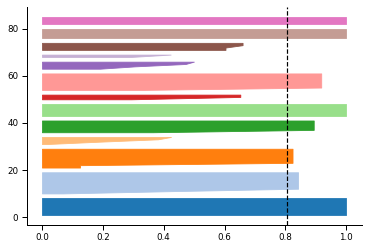

In [27]:
plt.figure()

plot_silhouette_sample(silhouette_sample, clusters, silhouette_avg)

In [28]:
def plot_time_clusters(times, clusters, ax=None, cmap=plt.cm.tab10) :

    n_plots = len(clusters.shape)
    n_t = len(times)
    n_clust_arr = [len(set(clusters_i)) for clusters_i in clusters]

    if n_plots > 1 : 
        for i, clusters_i in enumerate(clusters) :

            n_clust = len(set(clusters_i))

            ax.scatter(times, (i+1) * np.ones(n_t), c=clusters_i, 
            cmap=cmap, vmin=1, vmax=n_colors)

    ax.set_ylabel("Max # clusters")
    ax.set_xlabel("Times (min)")

    ax2 = ax.twinx()
    ax2.set_ylim(ax.get_ylim())
    ax2.set_yticks(maxclust_range)
    ax2.set_yticklabels(n_clust_arr)
    ax2.set_ylabel("Actual # clusters")

    ax.set_title(f"Method: {method}")
    

Text(0, 0.5, 'silhouette score')

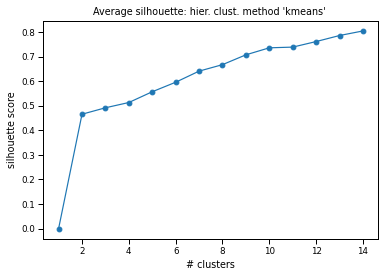

In [29]:
fig, ax = plt.subplots()

ax.plot(n_clust_arr, silhouette_avg_arr, 'o-')

ax.set_title(f"Average silhouette: hier. clust. method '{method}' ")
ax.set_xlabel("# clusters")
ax.set_ylabel("silhouette score")

# plt.savefig(f"hierarchical_clustering_methods_silhouette_comparison.png")

In [30]:
method = "complete"
maxclust = 6

linked = shc.linkage(dist_mat_condensed, method=method) #"ward")


# clusters = shc.fcluster(linked, d_max, criterion='distance')
clusters = shc.fcluster(linked, maxclust, criterion='maxclust')

In [31]:



methods = ['single', 'complete', 'average', 'ward']
i = 0
method = methods[i]

for i, method in enumerate(methods) :
    
    listsizes = []
    scores = []
    
    print(i)
    
    linked = shc.linkage(dist_mat_condensed, method=method) #"ward")

    for nclust_max in range(2, 102):
        clusters = shc.fcluster(linked, nclust_max, criterion='maxclust')
    #    print(nclust,lab)
        n_clust = max(clusters)
    #     print(nclust_max, n_clust)

        if n_clust > 1:
            score = metrics.silhouette_score(dist_mat_full, clusters, metric="precomputed")
           # print(nclust,max(lab),lab,score) 
            listsizes.append(n_clust)
            scores.append(score)
    #         print(n_clust, score)
    #         print(metrics.silhouette_samples(dist_mat_full, clusters))

    plt.plot(listsizes, scores,'o-', c=f'C{i}', label=method, alpha=0.8)

plt.legend()

plt.title(f"Hierarchical clustering methods comparison by average silhouette")
plt.xlabel("# clusters")
plt.ylabel("silhouette score")

# plt.savefig(f"hierarchical_clustering_methods_silhouette_comparison.png")

0


NameError: name 'dist_mat_full' is not defined

In [32]:
# compute silhouette for each sample

methods = ['single', 'complete', 'average', 'ward']
i = 3
method = methods[i]
linked = shc.linkage(dist_mat_condensed, method=method) #"ward")

nclust_max = 2
clusters = shc.fcluster(linked, nclust_max, criterion='maxclust')
n_clust = max(clusters)
print(n_clust)

silouhette_avg = metrics.silhouette_score(dist_mat_full, clusters, metric="precomputed")


# Compute the silhouette scores for each sample
sample_silhouette_values = metrics.silhouette_samples(dist_mat_full, clusters, metric="precomputed")

fig, ax = plt.subplots(1, 1)

y_lower = 1
for i in range(1, n_clust+1):
    # Aggregate the silhouette scores for samples belonging to
    # cluster i, and sort them
    ith_cluster_silhouette_values = sample_silhouette_values[clusters == i]

    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / n_clust)
    ax.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values,
                      facecolor=f"C{i-1}", edgecolor=f"C{i-1}", alpha=1)

    # Label the silhouette plots with their cluster numbers at the middle
    ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    # Compute the new y_lower for next plot
    hpad = 1
    y_lower = y_upper + hpad  # 10 for the 0 samples
    
ax.axvline(x=silouhette_avg, c='k', ls='--')

# ax.set_ylim(1, len(clusters) + n_clust*hpad)

# ax.set_title(f"The silhouette plot for the {n_clust} clusters.")
ax.set_xlabel("The silhouette coefficient values")
ax.set_ylabel("Cluster label")
ax.set_yticks([])
sb.despine()

ax.set_title(f'Silhouette (sample): {method} method, {n_clust} clusters')

plt.tight_layout()

plt.savefig(f"sample_silhouette_method_{method}_{n_clust}_clusters.png", dpi=250, bbox_inches='tight')

2


NameError: name 'dist_mat_full' is not defined